In [1]:
import keras
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Input, Flatten, concatenate, Dense, Activation, AveragePooling2D
from keras.models import Sequential, Model
from keras.datasets import mnist
from keras.utils import to_categorical, plot_model
from keras.optimizers import SGD

from IPython.display import Image

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#数据变成TensorFow为Backend的形式
x_train=x_train.reshape(60000,28,28,1)
x_test=x_test.reshape(10000,28,28,1)
#把标签变成one-hot编码的形式
y_train=to_categorical(y_train,num_classes=10)
y_test=to_categorical(y_test,num_classes=10)

In [3]:
DenseNetB = True
DenseNetC = True
NB_BLOCKS = 2
NB_DEPTH = 5
GROWTH_RATE = 3
COMPRESSION_FACTOR = 0.5

In [4]:
 def composite_function(x, growth_rate):
    if DenseNetB: #Add 1*1 convolution when using DenseNet B
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(kernel_size=(1,1), strides=1, filters = 4 * growth_rate, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Conv2D(kernel_size=(3,3), strides=1, filters = growth_rate, padding='same')(x)
    return output

def dense_block(x, depth=5, growth_rate = 3):
    nb_input_feature_map = x.shape[3].value
    stored_features = x
    for i in range(depth):
        feature = composite_function(stored_features, growth_rate = growth_rate)
        stored_features = concatenate([stored_features, feature], axis=3)
    return stored_features

def dense_net(input_image, nb_blocks = 2):
    x = Conv2D(kernel_size=(3,3), filters=8, strides=1, padding='same', activation='relu')(input_image)
    for block in range(nb_blocks):
        x = dense_block(x, depth=NB_DEPTH, growth_rate = GROWTH_RATE)
        if not block == nb_blocks-1:
            if DenseNetC:
                theta = COMPRESSION_FACTOR
            nb_transition_filter =  int(x.shape[3].value * theta)
            x = Conv2D(kernel_size=(1,1), filters=nb_transition_filter, strides=1, padding='same', activation='relu')(x)
        x = AveragePooling2D(pool_size=(2,2), strides=2)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)
    return outputs

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

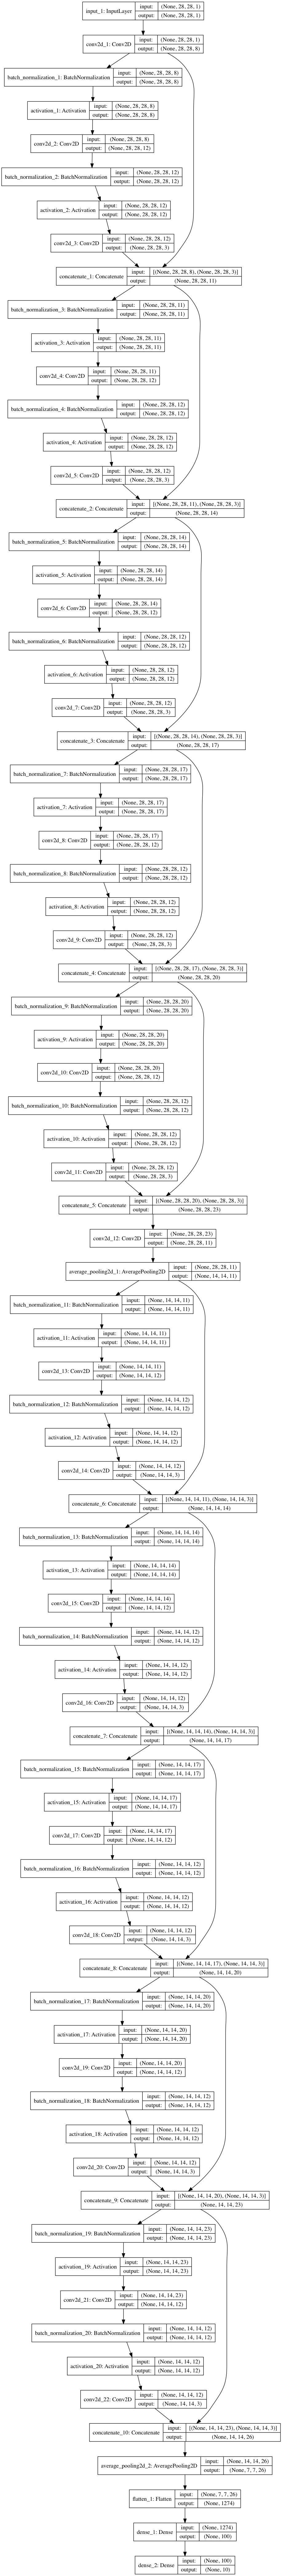

In [5]:
input_image = Input((28,28,1))
denseNet = Model(input_image, dense_net(input_image, NB_BLOCKS))
denseNet.summary()
plot_model(denseNet, to_file="denseNet.png", show_shapes=True)
Image('denseNet.png')

In [6]:
denseNet.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
history_denseNet = denseNet.fit(x_train, y_train, batch_size=128, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 484s 8ms/step - loss: 0.3151 - acc: 0.9156
Epoch 2/5
60000/60000 [==============================] - 459s 8ms/step - loss: 0.1069 - acc: 0.9678
Epoch 3/5
60000/60000 [==============================] - 470s 8ms/step - loss: 0.0800 - acc: 0.9758
Epoch 4/5
60000/60000 [==============================] - 456s 8ms/step - loss: 0.0665 - acc: 0.9796
Epoch 5/5
60000/60000 [==============================] - 450s 7ms/step - loss: 0.0571 - acc: 0.9825


In [7]:
score=denseNet.evaluate(x_test,y_test)
print("Testing Loss:", score[0])
print("Testing Accuracy of:", score[1])

10000/10000 [==============================] - 26s 3ms/step
Testing Loss: 0.0616552430503536
Testing Accuracy of: 0.9792
